# PBMC3k dataset

In [1]:
import os
import subprocess

whoami = subprocess.run("whoami", stdout=subprocess.PIPE)
if (b'jovyan' in whoami.stdout) & (not os.path.isfile("/home/jovyan/data/pbmc3k.h5ad")):
    !sh /home/jovyan/data/pbmc3k.sh

In [2]:
from typing import NamedTuple
import warnings
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

from tools.preferences import kwarg_savefig
from tools.preprocessing import get_quantiles, filter_pipeline
from tools.go import top_degs, get_deg, go_plot

In [3]:
class Config(NamedTuple):
    data: ad.AnnData = sc.read_h5ad("/home/jovyan/data/pbmc3k.h5ad")
    export: str = "/home/jovyan/output/pbmc3k"
    dsname: str = "PBMC3k"
    
conf = Config()
os.makedirs(conf.export, exist_ok=True)
warnings.filterwarnings("ignore")

In [4]:
sc.pp.filter_cells(conf.data, min_genes=200)
sc.pp.filter_genes(conf.data, min_cells=3)
conf.data.uns["dsname"] = conf.dsname

In [5]:
conf.data

AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'
    uns: 'dsname'

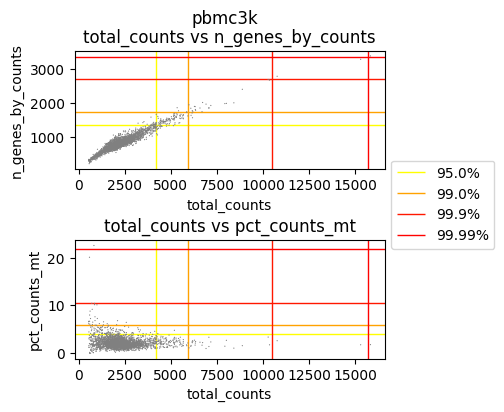

In [6]:
for k, v in {"pbmc3k": conf.data}.items():
    v.var['mt'] = v.var_names.str.startswith('MT-')
    sc.pp.calculate_qc_metrics(v, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    
    fig, ax = plt.subplots(2, 1, figsize=(4, 4))
    plt.subplots_adjust(hspace=.6)

    for a, y in zip(ax, ["n_genes_by_counts", "pct_counts_mt"]):
        sc.pl.scatter(v, x="total_counts", y=y, ax=a, size=3, show=False)
        area = [.95, .99, .999, .9999]
        xlims, ylims = a.get_xlim(), a.get_ylim()
        for xval, yval, q in zip(
            get_quantiles(v, "total_counts", area=area),
            get_quantiles(v, y, area=area),
            area
        ):
            kwargs = dict(
                zorder=-1, linewidth=1, 
                color=plt.cm.autumn_r(q ** 100)
            )
            a.vlines(xval, *ylims, **kwargs)
            a.hlines(yval, *xlims, label=f"{100 * q}%", **kwargs)
        if y == "n_genes_by_counts":
            a.legend(loc="center left", bbox_to_anchor=(1, -.3))
        a.set_title(f"total_counts vs {y}")
        a.set(xlim=xlims, ylim=ylims)
        

    fig.suptitle(
        k,
        verticalalignment="center",
        y=.96
    );
    
    fig.savefig(f"{conf.export}/qc.png", **kwarg_savefig)

In [7]:
filter_dict = {
    "n_genes_by_counts": lambda x: x < 2500,
    "pct_counts_mt": lambda x: x < 10
}

In [8]:
conf = Config(data=filter_pipeline(conf.data, filter_dict))

In [9]:
sc.pp.normalize_total(conf.data, target_sum=1e6)
sc.pp.log1p(conf.data, base=2)

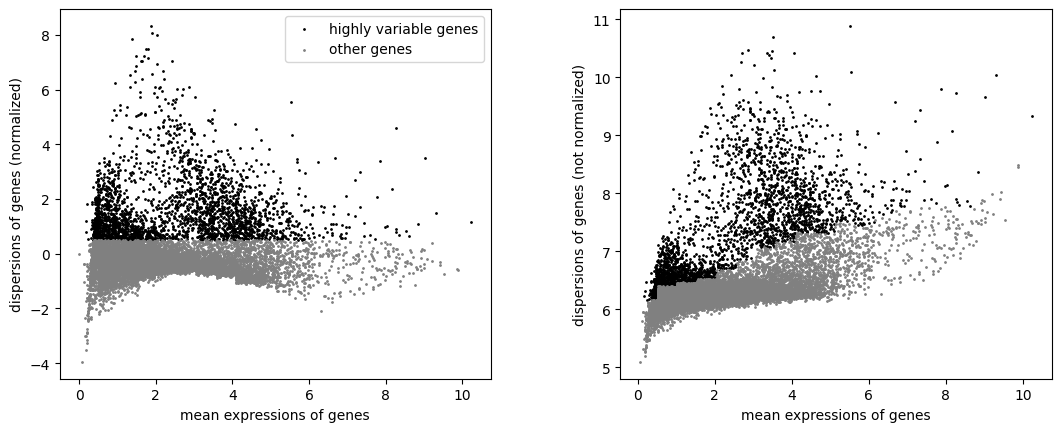

In [11]:
sc.pp.highly_variable_genes(
    conf.data, min_mean=0.0125, max_mean=15, min_disp=0.5
)
sc.pl.highly_variable_genes(conf.data, show=False)
plt.savefig(f"{conf.export}/hvg.png", **kwarg_savefig)

In [12]:
sc.tl.pca(conf.data, svd_solver='arpack')

In [13]:
sc.pp.neighbors(conf.data, n_pcs=50)

In [14]:
sc.tl.umap(conf.data)

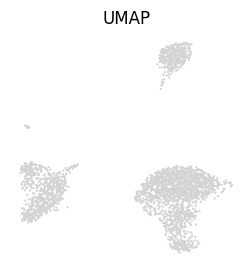

In [15]:
fig, ax = plt.subplots(figsize=(3, 3))

sc.pl.umap(conf.data, ax=ax, size=10, show=False)
ax.axis("off");
ax.set(title=f"UMAP", xlabel="UMAP1", ylabel="UMAP2");

In [16]:
sc.tl.leiden(conf.data, resolution=1)

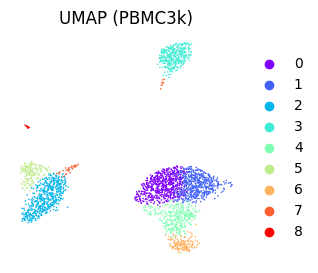

In [17]:
fig, ax = plt.subplots(figsize=(3, 3))

sc.pl.umap(conf.data, color="leiden", ax=ax, size=5, show=False, palette="rainbow")
ax.axis("off");
ax.set(title=f"UMAP ({conf.dsname})", xlabel="UMAP1", ylabel="UMAP2");

fig.savefig(f"{conf.export}/umap.png", **kwarg_savefig)

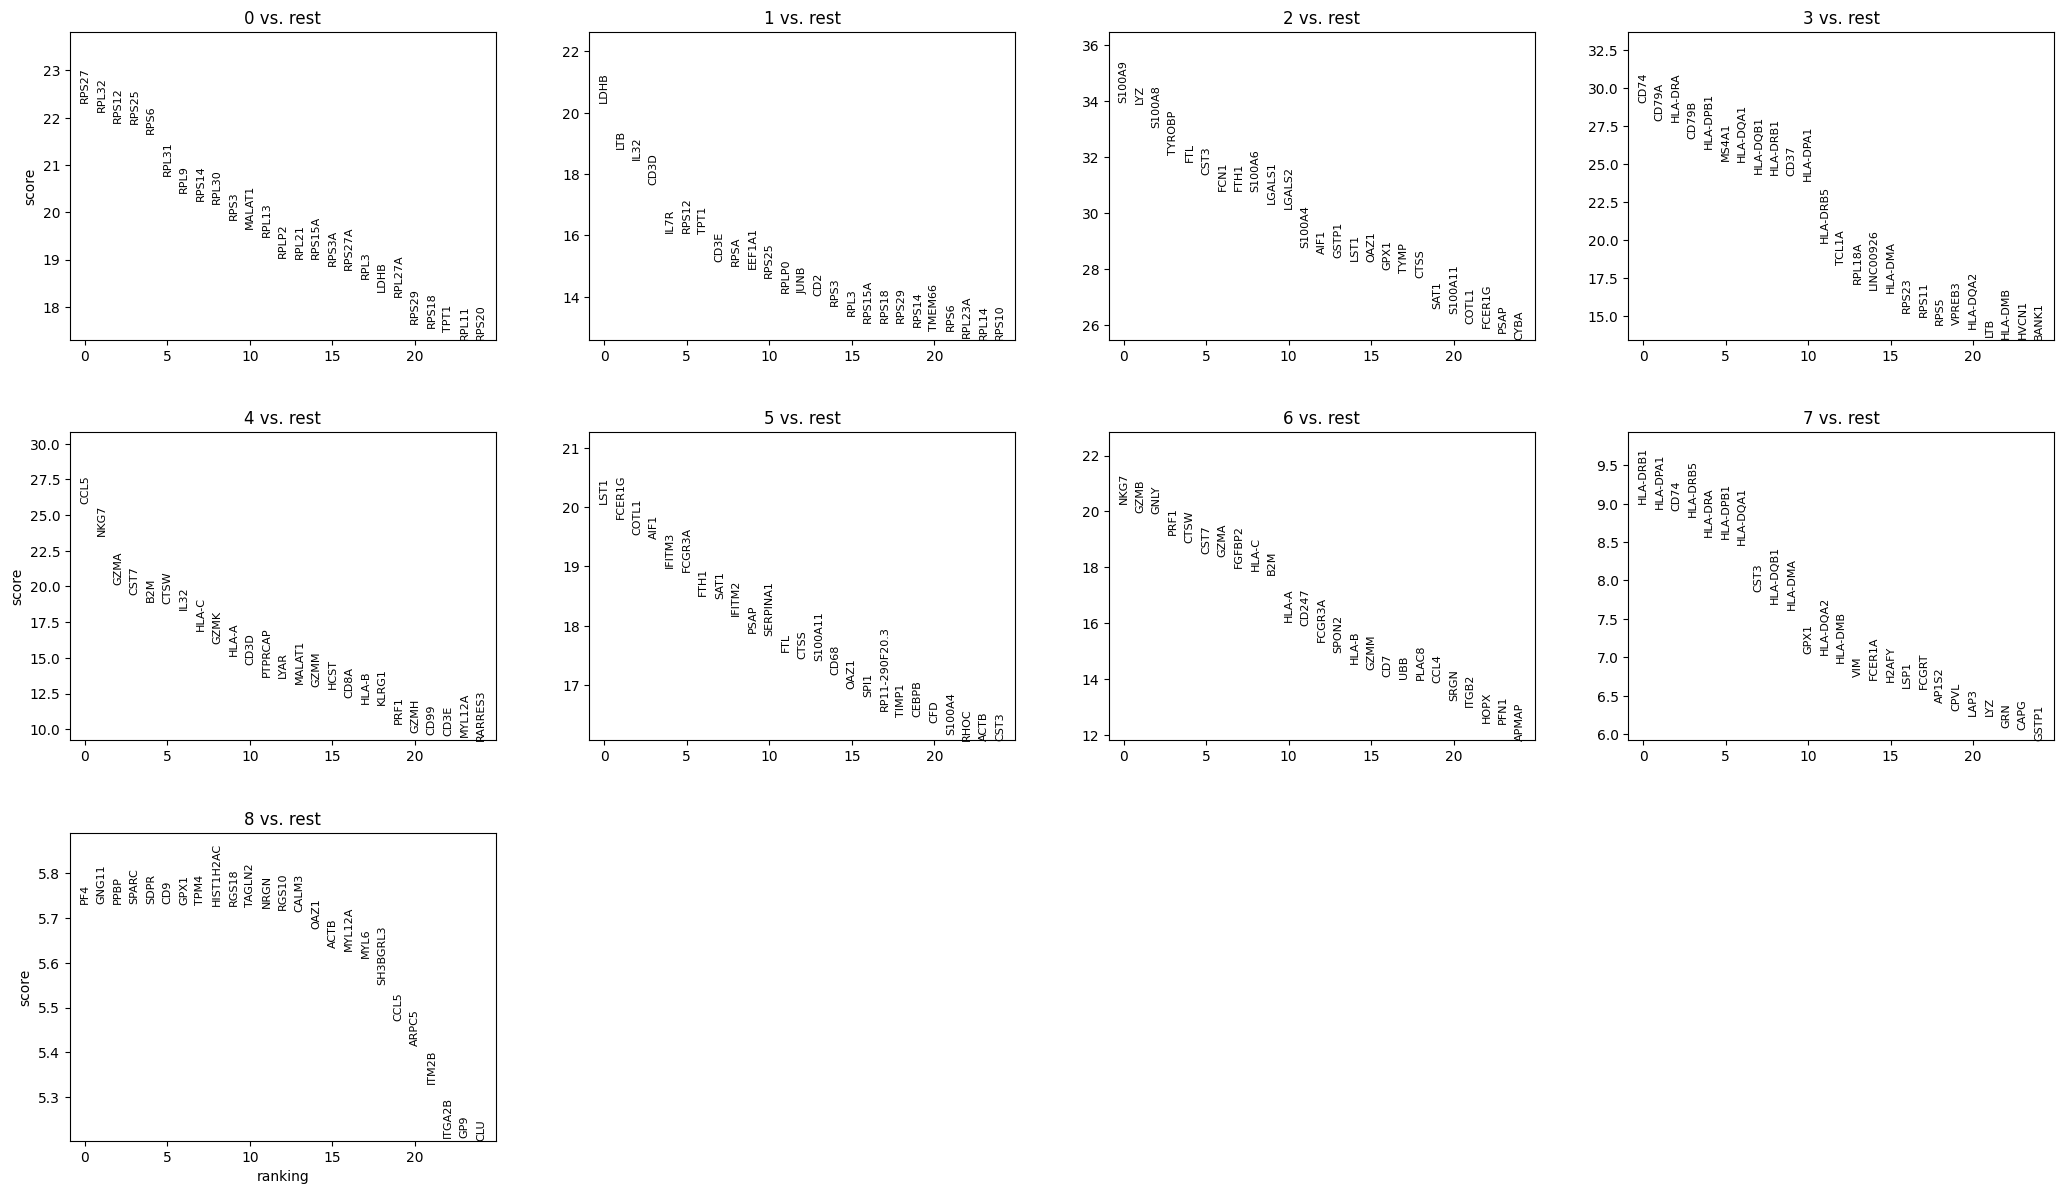

In [17]:
sc.tl.rank_genes_groups(conf.data, "leiden", method='wilcoxon')
sc.pl.rank_genes_groups(conf.data, n_genes=25, sharey=False)

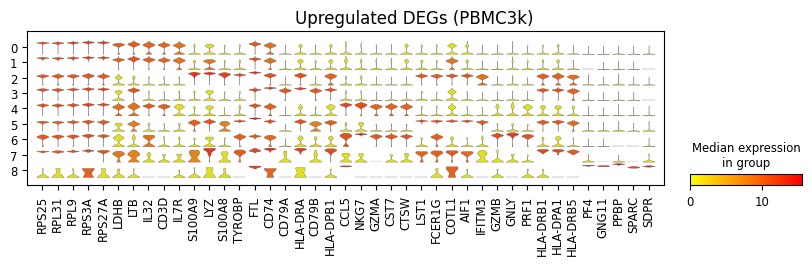

In [18]:
n = 5

fig, ax = plt.subplots(figsize=(10, 2))
sc.pl.stacked_violin(
    conf.data, top_degs(conf.data, n, min_logfc=1),
    groupby="leiden", cmap="autumn_r", 
    ax=ax, show=False, figsize=(10, 2)
)
ax.set_title(f"Upregulated DEGs ({conf.dsname})")

fig.savefig(
    f"{conf.export}/sigup_violin.png",
    **kwarg_savefig
)

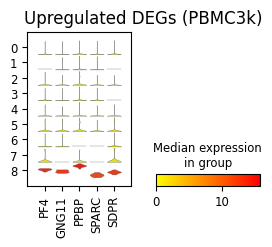

In [46]:
fig, ax = plt.subplots(figsize=(3, 2))
sc.pl.stacked_violin(
    conf.data, get_deg(conf.data, "8", min_logfc=1)[:5],
    groupby="leiden", cmap="autumn_r", 
    ax=ax, show=False, figsize=(3, 2)
)
ax.set_title(f"Upregulated DEGs ({conf.dsname})")

fig.savefig(
    f"{conf.export}/sigup_violin_8.png",
    **kwarg_savefig
)

In [22]:
from grnet.clusters import CellClasses
from grnet.models import PC, PretrainedModel
from grnet.plot import grnplot, planetplot

In [24]:
lst_data = [
    [
        conf.data[
            conf.data.obs["leiden"] == cluster_id,
            get_deg(conf.data, name, min_logfc=1)[:5]
        ] for cluster_id in conf.data.uns["rank_genes_groups"]["names"].dtype.names
    ] for name in conf.data.uns["rank_genes_groups"]["names"].dtype.names
]

In [25]:
models = [
    PC(lst_data[i // 9][i % 9].to_df()) for i in range(9 ** 2)
]

for m in models:
    m.estimate()

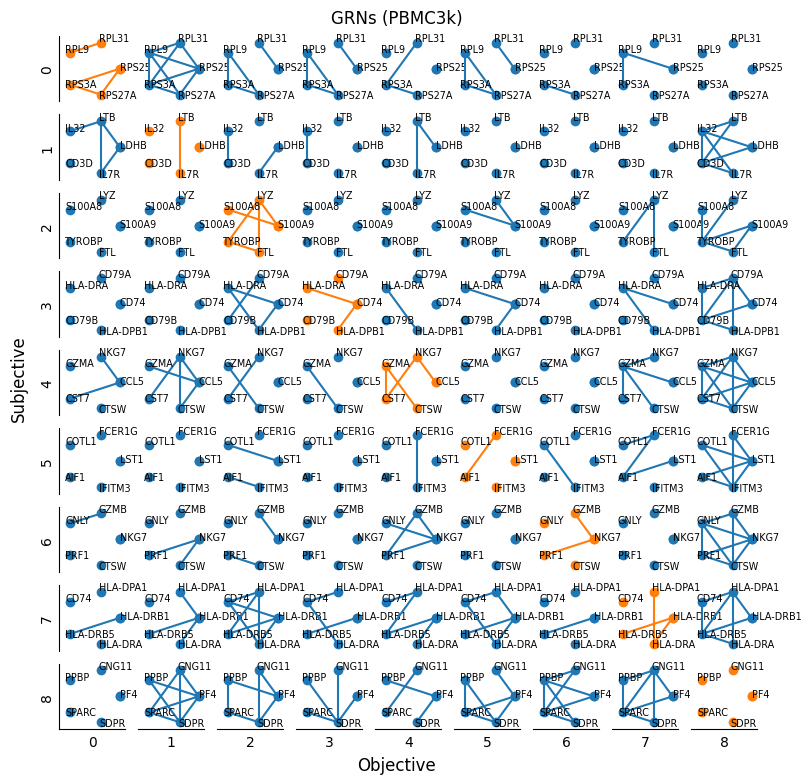

In [26]:
fig, ax = plt.subplots(9, 9, figsize=(9, 9))

for (i, m), a in zip(enumerate(models), ax.ravel()):
    grnplot(m, ax=a, color="C1" if i // 9 == i % 9 else "C0")
    names = conf.data.uns["rank_genes_groups"]["names"].dtype.names
    a.spines['left'].set_visible(i % 9 == 0)
    a.spines['bottom'].set_visible(i // 9 == 8)
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.tick_params(
        axis='both', which='both', 
        bottom=False, top=False, left=False, right=False, 
        labelbottom=False, labelleft=False
    )
    a.axis("on") if (i // 9 == 8) | (i % 9 == 0) else None
    a.set(
        xlabel=names[i % 9] if i // 9 == 8 else "",
        ylabel=names[i // 9] if i % 9 == 0 else ""
    )
fig.supylabel("Subjective", x=.07)
fig.supxlabel("Objective", y=.06)
fig.suptitle(f"GRNs ({conf.dsname})", y=.91)

fig.savefig(f"{conf.export}/grns.png", **kwarg_savefig)

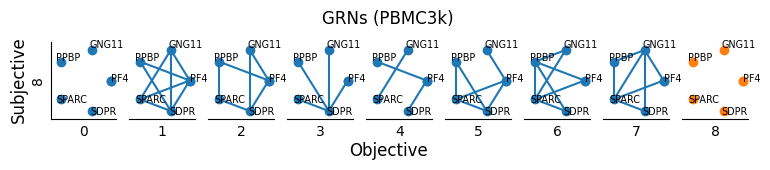

In [39]:
fig, ax = plt.subplots(1, 9, figsize=(9, 1))

for (i, m), a in zip(enumerate(models[-9:]), ax.ravel()):
    grnplot(m, ax=a, color="C1" if i == 8 else "C0")
    names = conf.data.uns["rank_genes_groups"]["names"].dtype.names
    a.spines['left'].set_visible(i % 9 == 0)
    a.spines['bottom'].set_visible(True)
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.tick_params(
        axis='both', which='both', 
        bottom=False, top=False, left=False, right=False, 
        labelbottom=False, labelleft=False
    )
    a.axis("on")
    a.set(
        xlabel=names[i % 9],
        ylabel=8 if i % 9 == 0 else ""
    )
fig.supylabel("Subjective", x=.08)
fig.supxlabel("Objective", y=-.3)
fig.suptitle(f"GRNs ({conf.dsname})", y=1.2)

fig.savefig(f"{conf.export}/grns_for_8.png", **kwarg_savefig)


NOTE: Dependency discovery took 43 seconds during snapshot.
Consider using .renvignore to ignore files, or switching to explicit snapshots.
See `?renv::dependencies` for more information.



Could not mmap compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.



NOTE: Dependency discovery took 44 seconds during snapshot.
Consider using .renvignore to ignore files, or switching to explicit snapshots.
See `?renv::dependencies` for more information.



Could not mmap compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.



NOTE: Dependency discovery took 45 seconds during snapshot.
Consider using .renvignore to ignore files, or switching to explicit snapshots.
See `?renv::dependencies` for more information.



Could not mmap compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.



NOTE: Dependency discovery took 44 seconds during snapshot.
Consider using .renvignore to ignore files, or switching to explicit snapshots.
See `?renv::dependencies` for more information.



Could not mmap compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.



NOTE: Dependency discovery took 45 seconds during snapshot.
Consider using .renvignore to ignore files, or switching to explicit snapshots.
See `?renv::dependencies` for more information.



Could not mmap compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.



NOTE: Dependency discovery took 45 seconds during snapshot.
Consider using .renvignore to ignore files, or switching to explicit snapshots.
See `?renv::dependencies` for more information.



Could not mmap compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.



NOTE: Dependency discovery took 45 seconds during snapshot.
Consider using .renvignore to ignore files, or switching to explicit snapshots.
See `?renv::dependencies` for more information.



Could not mmap compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.



NOTE: Dependency discovery took 46 seconds during snapshot.
Consider using .renvignore to ignore files, or switching to explicit snapshots.
See `?renv::dependencies` for more information.



Could not mmap compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.



NOTE: Dependency discovery took 47 seconds during snapshot.
Consider using .renvignore to ignore files, or switching to explicit snapshots.
See `?renv::dependencies` for more information.



Could not mmap compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.


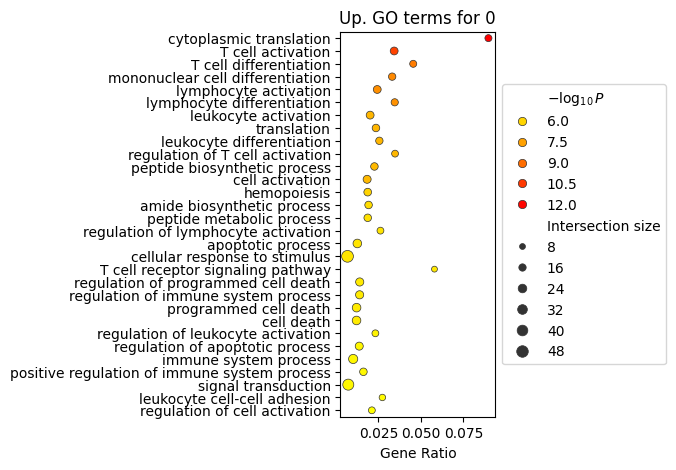

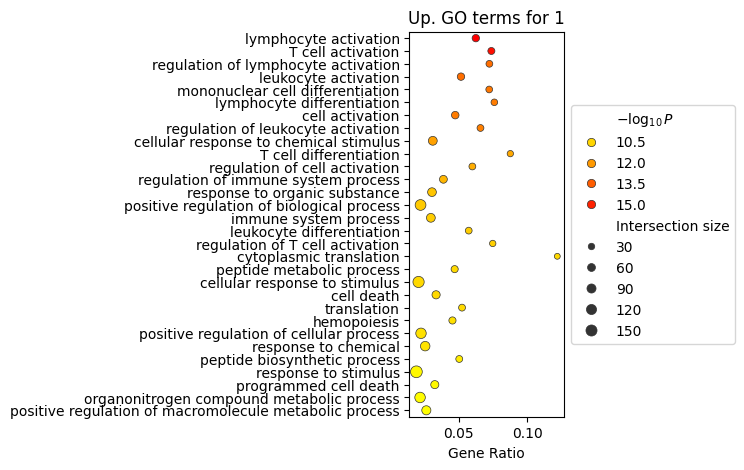

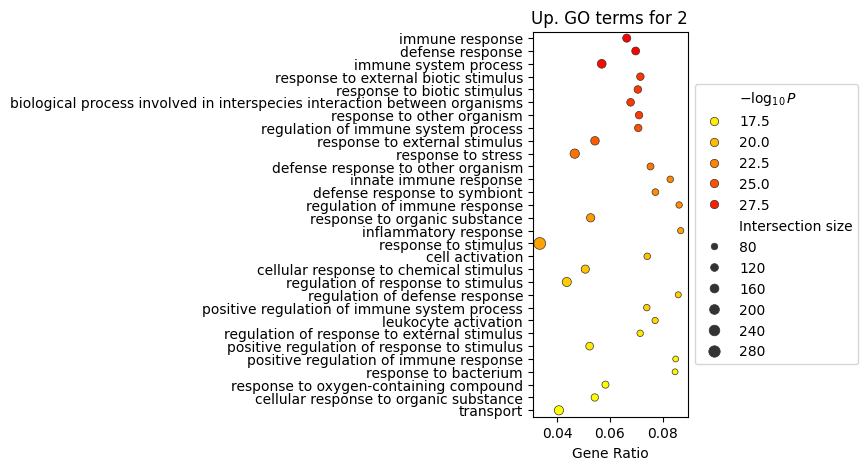

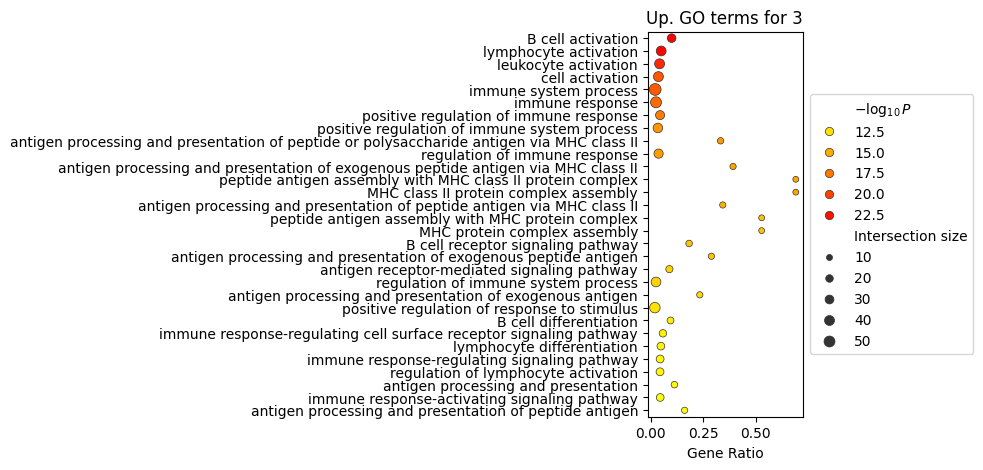

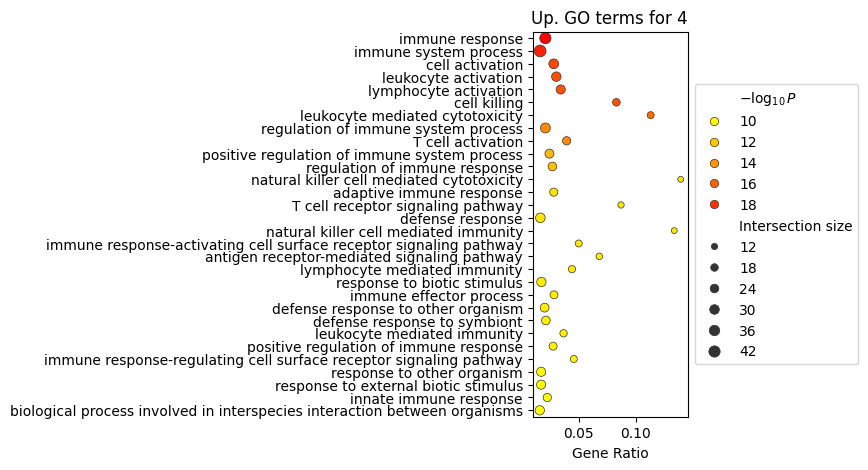

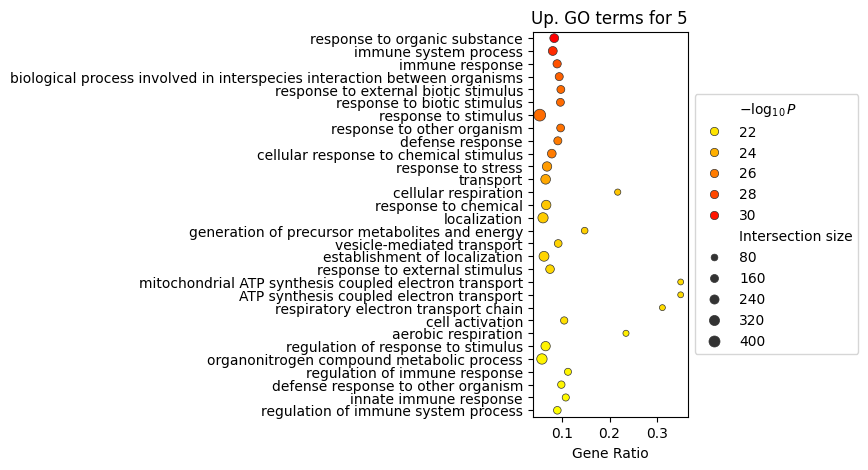

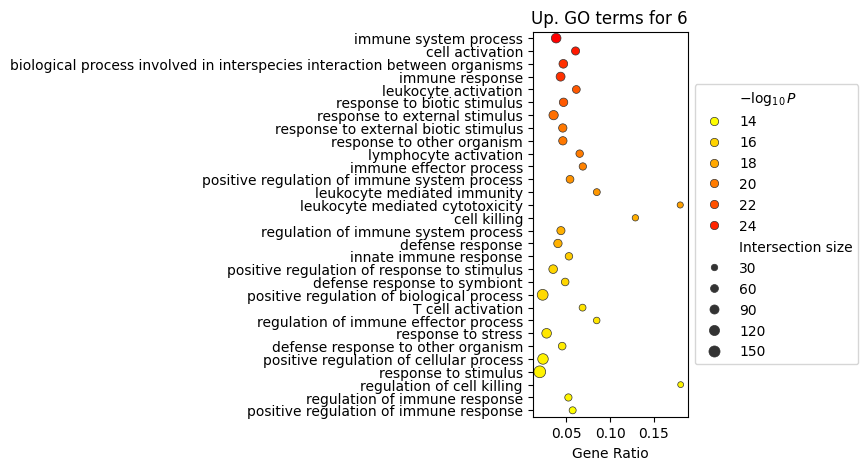

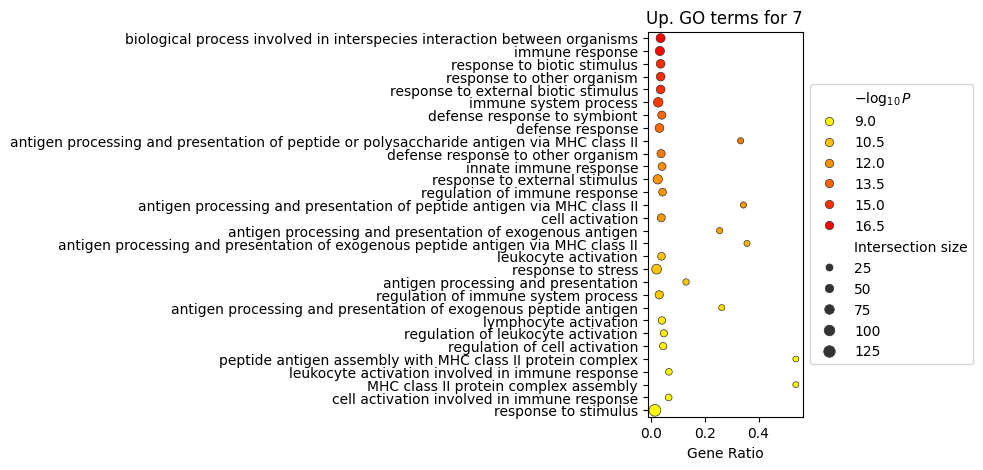

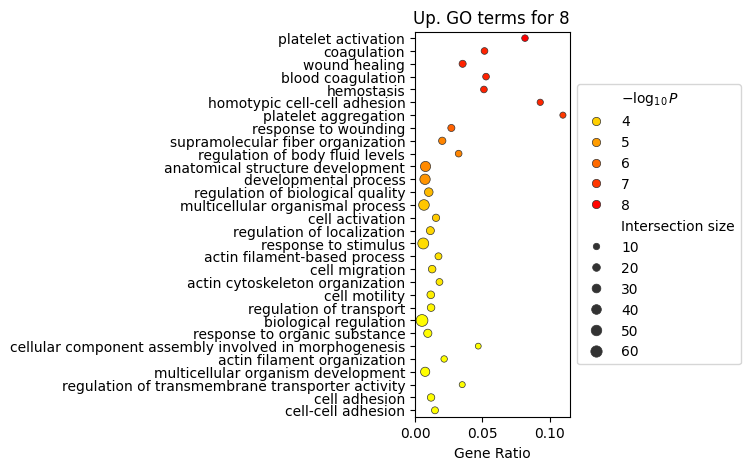

In [44]:
for k in conf.data.uns["rank_genes_groups"]["names"].dtype.names:
    if get_deg(conf.data, k, min_logfc=1).size != 0:
        fig, ax = plt.subplots(figsize=(2, 5))
        go_plot(conf.data, cluster_name=k, min_logfc=1, top=30, ax=ax, palette="autumn_r")
        ax.set_title(f"Up. GO terms for {k}", loc="right")
        fig.savefig(f"{conf.export}/go_{k}.png", **kwarg_savefig)

In [40]:
from grnet.evaluations import d_asterisk

In [41]:
metric_matrix = pd.DataFrame(
    np.array(
        [d_asterisk(
            models[9 * (i // 9) + (i // 9)].get_matrix(), 
            models[i].get_matrix()
        ) for i in range(9 ** 2)]
    ).reshape(9, 9),
    index=conf.data.uns["rank_genes_groups"]["names"].dtype.names,
    columns=conf.data.uns["rank_genes_groups"]["names"].dtype.names
)

In [42]:
import seaborn as sns

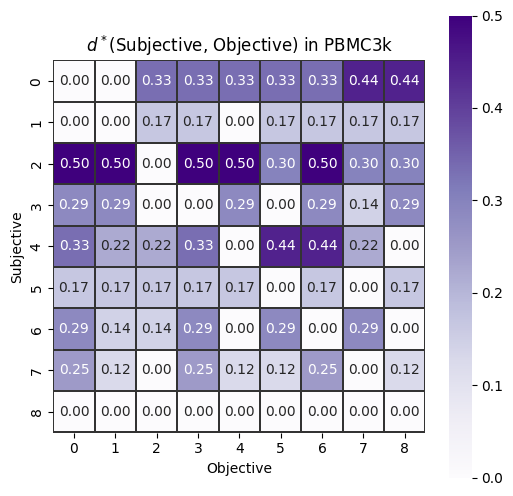

In [43]:
fig, ax = plt.subplots(figsize=(6, 6))

sns.heatmap(
    data=metric_matrix,
    square=True, vmin=0,
    annot=True, fmt=".2f",
    cmap="Purples", ax=ax,
    linewidth=.1, linecolor=".2"
)

ax.set(
    ylabel="Subjective", 
    xlabel="Objective", 
    title="$d^*$" + "(Subjective, Objective)" + f" in {conf.dsname}"
);

fig.savefig(f"{conf.export}/dasterisk.png", **kwarg_savefig)

In [123]:
new_datalist = [
    conf.data[
        conf.data.obs["leiden"] == cluster_id,
        get_deg(conf.data, "8", pvals_adj=p, min_logfc=1)[:10]
    ] for cluster_id in conf.data.uns["rank_genes_groups"]["names"].dtype.names
]

new_models = [
    PC(new_datalist[i].to_df()) for i in range(9)
]

for m in new_models:
    m.estimate()

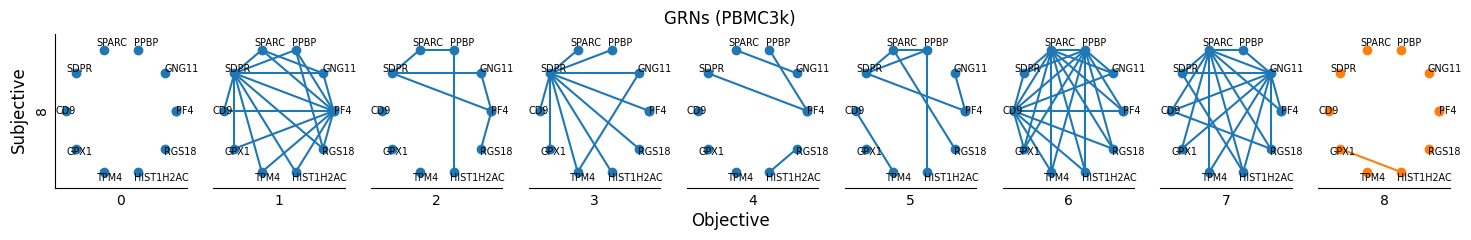

In [140]:
fig, ax = plt.subplots(1, 9, figsize=(18, 2))

for (i, m), a in zip(enumerate(new_models), ax.ravel()):
    grnplot(m, ax=a, color="C1" if i == 8 else "C0")
    names = conf.data.uns["rank_genes_groups"]["names"].dtype.names
    a.spines['left'].set_visible(i % 9 == 0)
    a.spines['bottom'].set_visible(True)
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.tick_params(
        axis='both', which='both', 
        bottom=False, top=False, left=False, right=False, 
        labelbottom=False, labelleft=False
    )
    a.axis("on")
    a.set(
        xlabel=names[i % 9],
        ylabel=8 if i % 9 == 0 else ""
    )
fig.supylabel("Subjective", x=.1)
fig.supxlabel("Objective", y=-.1)
fig.suptitle(f"GRNs ({conf.dsname})", y=1)

# fig.savefig(f"{conf.export}/grns_for_8.png", **kwarg_savefig)

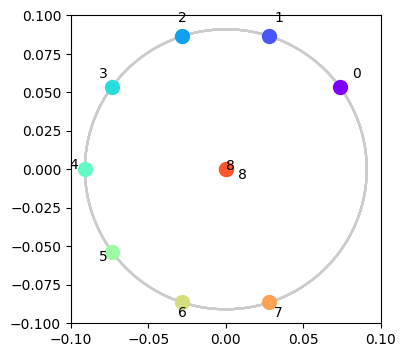

In [147]:
newds = CellClasses(
    models=new_models,
    colors="rainbow"
)

planetplot(subjective=newds, objective=newds, id=8, s=100)

# ML model

In [18]:
import optuna, lightgbm, shap

In [19]:
import optuna.integration.lightgbm as lgb
import lightgbm as lgbm

from sklearn.model_selection import train_test_split

In [20]:
def encoder(series: pd.Series) -> pd.Series:
    conversion_dict = {
        v: i for i, v in enumerate(series.unique())
    }
    return pd.Series(
        [conversion_dict[v] for v in series],
        series.index
    )

In [32]:
x_tr, x_te, y_tr, y_te = train_test_split(
    conf.data.to_df(), 
    conf.data.obs["leiden"].astype(int),
    test_size=.2,
    random_state=0
)

x_tr, x_v, y_tr, y_v = train_test_split(
    x_tr, y_tr,
    test_size=.25,
    random_state=0
)

train = lgbm.Dataset(x_tr, y_tr)
valid = lgbm.Dataset(x_v, y_v)
test = lgbm.Dataset(x_te, y_te)

# params = dict(
#     objective="binary", metric="binary_logloss",
#     verbosity=-1, deterministic=True,
#     random_seed=0, num_boost_round=100,
#     force_col_wise=True
# )

params = dict(
    objective="multiclass", 
    metric="multi_logloss",
    num_class=conf.data.obs["leiden"].unique().size,
    verbosity=-1, deterministic=True,
    random_seed=0, num_boost_round=100,
    force_col_wise=True
)

In [33]:
model = lgb.LightGBMTuner(
    params, train,
    valid_sets=valid,
    optuna_seed=0,
    verbosity=-1,
    callbacks=[lgbm.early_stopping(50), lgbm.log_evaluation(1000)]
)

In [34]:
%%capture
model.run()

In [35]:
tuned = model.get_best_booster()

In [36]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    roc_curve, roc_auc_score, 
    precision_recall_curve, 
    average_precision_score
)

In [79]:
label_bin

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [37]:
class roc_multi():
    def __init__(self, model, x, y):
        self.x = [
            roc_curve(y[:, i], model.predict(x)[:, i])[0] for i in range(y.shape[1])
        ]
        self.y = [
            roc_curve(y[:, i], model.predict(x)[:, i])[1] for i in range(y.shape[1])
        ]
        self.thresh = [
            roc_curve(y[:, i], model.predict(x)[:, i])[2].tolist() for i in range(y.shape[1])
        ]
        self.auc = [
            roc_auc_score(y[:, i], model.predict(x)[:, i], multi_class='ovr') for i in range(y.shape[1])
        ]

In [93]:
def plot_roc(model, x, y, ax, cmap, label_dict):
    assert len(ax.ravel()) >= 4, \
        f"At least 4 subplots are required; got {ax}"
    
    roc = roc_multi(model, x, y)
    ax = ax.ravel()
    
    for (i, x_), y_, auc, label in zip(enumerate(roc.x), roc.y, roc.auc, label_dict):
        ax[i].plot(x_, y_, label=f"{label} (AUC:{auc.round(3)})", c=eval(f"plt.cm.{cmap}")(i/len(roc.auc)))
    
    ax[-1].plot(
        [0] + np.linspace(0, 1, 100).tolist(), 
        [0] + np.stack([
            np.interp(np.linspace(0, 1, 100), x, y) for x, y in zip(roc.x, roc.y)
        ]).mean(axis=0).tolist(),
        c="r",
        label=f"macro (AUC:{np.array(roc.auc).mean().round(2)})"
    )
    ax[-1].set_ylim(*ax[0].get_ylim())
    
    [sp.plot([0, 0, 1], [0, 1, 1], linestyle=(0, (1, 2)), c=".2", label="ideal", zorder=0) for sp in ax]
    [sp.plot([0, 1], [0, 1], c="gray", label="baseline", zorder=1, alpha=0.5) for sp in ax]
    [sp.set(xlabel="false positive rate", ylabel="true positive rate", title="ROC curve (OvR)") for sp in ax] 
    [sp.legend(fontsize="small") for sp in ax]

In [94]:
testx = x_te.iloc[np.argsort(y_te)]
testy = y_te[np.argsort(y_te)]

In [95]:
label_bin = label_binarize(
    testy,
    classes = testy.unique()
)

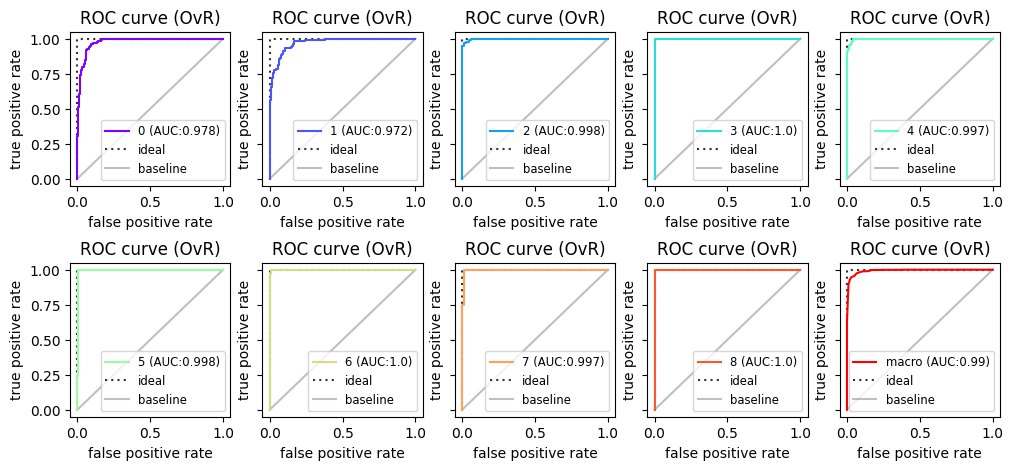

In [143]:
fig, ax = plt.subplots(2, 5, sharey=True, figsize=(12, 5))
plt.subplots_adjust(hspace=.5)

plot_roc(
    tuned, testx, label_bin, 
    ax, cmap="rainbow",
    label_dict={v: i for i, v in enumerate(testy.unique())}
)

fig.savefig(f"{conf.export}/roc.png", **kwarg_savefig)

In [103]:
class pr_multi():
    def __init__(self, model, x, y):
        self.x = [
            precision_recall_curve(y[:, i], model.predict(x)[:, i])[1] for i in range(y.shape[1])
        ]
        self.y = [
            precision_recall_curve(y[:, i], model.predict(x)[:, i])[0] for i in range(y.shape[1])
        ]
        self.thresh = [
            precision_recall_curve(y[:, i], model.predict(x)[:, i])[2].tolist() for i in range(y.shape[1])
        ]
        self.ap = [
            average_precision_score(y[:, i], model.predict(x)[:, i]) for i in range(y.shape[1])
        ]
        self.base = [len(y[:, i][y[:, i] == 1]) / len(y) for i in range(y.shape[1])]

In [104]:
def plot_pr(model, x, y, ax, cmap, label_dict):
    assert len(ax.ravel()) >= 4, \
        f"At least 4 subplots are required; got {ax}"
    
    pr = pr_multi(model, x, y)
    ax = ax.ravel()
    
    for (i, x_), y_, ap, label, base in zip(enumerate(pr.x), pr.y, pr.ap, label_dict, pr.base):
        ax[i].plot(x_, y_, label=f"{label} (AP:{ap.round(3)})", c=eval(f"plt.cm.{cmap}")(i/len(pr.ap)))
        ax[i].plot([0, 1], [base, base], c="gray", label="baseline", zorder=1, alpha=0.5)
    
    p_avg, r_avg, thr_avg = precision_recall_curve(y.ravel(), model.predict(x).ravel())
    
    ax[-1].plot(
        r_avg, p_avg, 
        c="r", 
        label=f"micro (AP:{average_precision_score(y, model.predict(x)).round(2)})"
    )
    base = np.array(pr.base).mean()
    ax[-1].plot([0, 1], [base, base], c="gray", label="baseline", zorder=1, alpha=0.5)
    ax[-1].set_ylim(*ax[0].get_ylim())
    
    [sp.plot([0, 1], [1, 1], linestyle=(0, (1, 2)), c=".2", label="ideal", zorder=2) for sp in ax]
    [sp.set(xlabel="recall", ylabel="precision", title="PR curve (OvR)") for sp in ax] 
    [sp.legend(fontsize="small") for sp in ax]

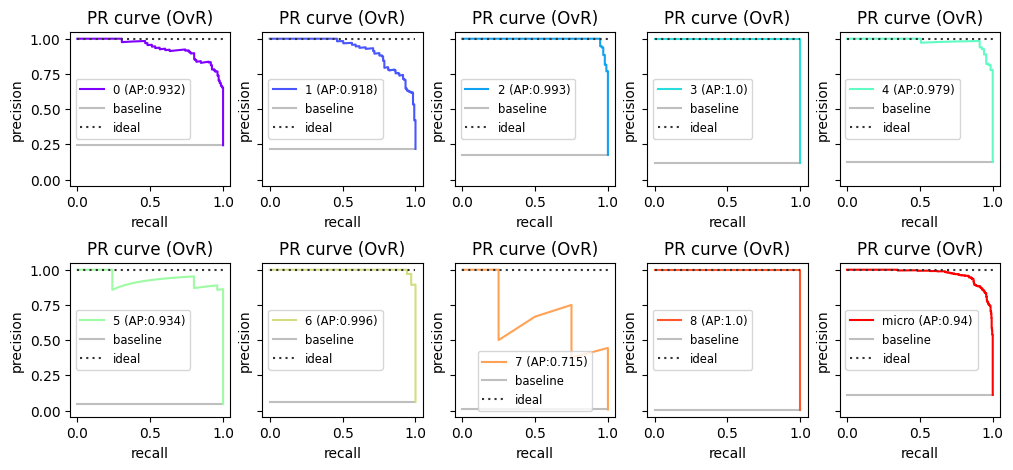

In [144]:
fig, ax = plt.subplots(2, 5, sharey=True, figsize=(12, 5))
plt.subplots_adjust(hspace=.5)

plot_pr(
    tuned, testx, label_bin, 
    ax, cmap="rainbow",
    label_dict={v: i for i, v in enumerate(testy)}
)

fig.savefig(f"{conf.export}/pr.png", **kwarg_savefig)

In [106]:
shap.initjs()

In [108]:
explainer = shap.TreeExplainer(model=tuned)
shap_values = explainer.shap_values(X=testx)

In [185]:
for i, v in enumerate(shap_values):
    plt.axes(title=f"cluster: {i} (PBMC3k)")
    shap.summary_plot(
        v, testx, 
        max_display=10, 
        show=False,
        plot_size=(4, 3),
    )
    plt.savefig(f"{conf.export}/shap_{i}.png", **kwarg_savefig)
    plt.close()

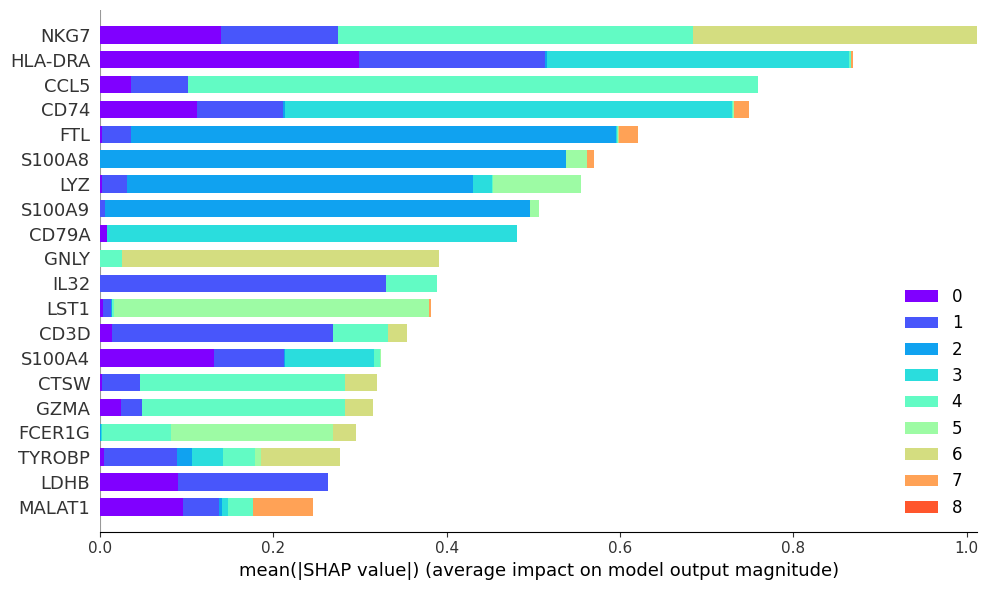

In [142]:
shap.summary_plot(
    shap_values, testx, 
    show=False, 
    color=lambda x: plt.cm.rainbow(x/9),
    plot_type="bar",
    plot_size=(10, 6),
    class_names=testy.unique(),
    class_inds="original"
)

plt.savefig(f"{conf.export}/shap.png", **kwarg_savefig)

In [157]:
df_fi = pd.DataFrame(
    tuned.feature_importance("gain"),
    index=conf.data.var.index,
    columns=["gain"]
).sort_values("gain", ascending=False)

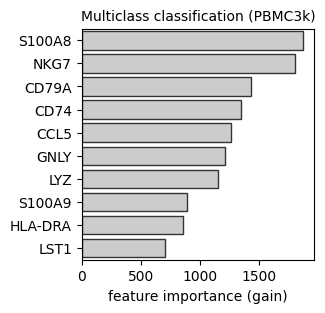

In [174]:
fig, ax = plt.subplots(figsize=(3, 3))

sns.barplot(
    data=df_fi.iloc[:10, :],
    x="gain",
    y=df_fi.iloc[:10, :].index,
    ax=ax, color=".8", edgecolor=".2"
)
ax.set(
    xlabel="feature importance (gain)",
    ylabel=""
)
ax.set_title(
    "Multiclass classification (PBMC3k)",
    size="medium"
)

plt.savefig(f"{conf.export}/fi.png", **kwarg_savefig)

In [212]:
ad_test = conf.data[testx.index]
ad_test.obs["prediction"] = np.argmax(
    tuned.predict(testx), 
    axis=1
).astype(str)

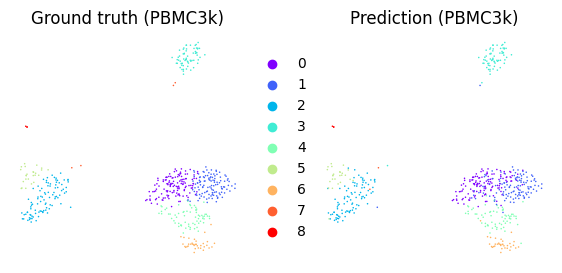

In [218]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
plt.subplots_adjust(wspace=.3)

for a, hue, title in zip(
    ax,
    ["leiden", "prediction"],
    ["Ground truth", "Prediction"]
):
    sc.pl.umap(
        ad_test, color=hue, 
        ax=a, size=5, show=False, 
        palette="rainbow"
    )
    a.axis("off");
    a.set(title=f"{title} ({conf.dsname})");
    a.get_legend().remove() if hue == "prediction" else None

fig.savefig(f"{conf.export}/umap_prediction.png", **kwarg_savefig)

In [225]:
ad_test.obs["tf"] = (
    ad_test.obs["leiden"] == ad_test.obs["prediction"]
).astype(str)

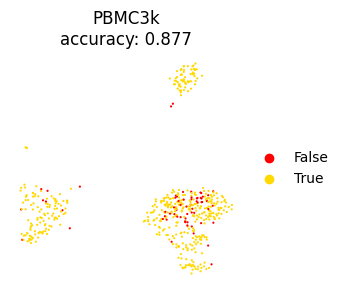

In [260]:
fig, ax = plt.subplots(figsize=(3, 3))

sc.pl.umap(
    ad_test, color="tf", 
    ax=ax, size=10, 
    show=False, palette=[plt.cm.autumn(i * 0.85) for i in range(2)]
)
acc = (
    ad_test.obs["tf"].value_counts() / ad_test.obs["tf"].size
)["True"]
ax.axis("off");
ax.set(title=f"{conf.dsname}" + "\n" + f"accuracy: {acc.round(3)}");

fig.savefig(f"{conf.export}/accuracy.png", **kwarg_savefig)

In [142]:
newds

In [118]:
new_models = [
    get_deg(conf.data, "8", pvals_adj=p, min_logfc=1)[:10]

array(['PF4', 'GNG11', 'PPBP', 'SPARC', 'SDPR', 'CD9', 'GPX1', 'TPM4',
       'HIST1H2AC', 'RGS18'], dtype=object)

In [61]:
models[0].get_matrix()

,RPS25,RPL31,RPL9,RPS3A,RPS27A
RPS25,1.0,0.0,0.0,1.0,1.0
RPL31,0.0,1.0,1.0,0.0,0.0
RPL9,0.0,0.0,1.0,0.0,0.0
RPS3A,0.0,0.0,0.0,1.0,1.0
RPS27A,0.0,0.0,0.0,0.0,1.0


In [37]:
[conf.data[name for name in conf.data.uns["rank_genes_groups"]["names"].dtype.names]

['0', '1', '2', '3', '4', '5', '6', '7', '8']

In [46]:
top_degs(conf.data, 5, pvals_adj=p, min_logfc=1)

array(['RPS25', 'RPL31', 'RPL9', 'RPS3A', 'RPS27A', 'LDHB', 'LTB', 'IL32',
       'CD3D', 'IL7R', 'S100A9', 'LYZ', 'S100A8', 'TYROBP', 'FTL', 'CD74',
       'CD79A', 'HLA-DRA', 'CD79B', 'HLA-DPB1', 'CCL5', 'NKG7', 'GZMA',
       'CST7', 'CTSW', 'LST1', 'FCER1G', 'COTL1', 'AIF1', 'IFITM3',
       'GZMB', 'GNLY', 'PRF1', 'HLA-DRB1', 'HLA-DPA1', 'HLA-DRB5', 'PF4',
       'GNG11', 'PPBP', 'SPARC', 'SDPR'], dtype=object)

In [34]:
get_deg(conf.data, "0", pvals_adj=p, min_logfc=1)[:5]

array(['RPS25', 'RPL31', 'RPL9', 'RPS3A', 'RPS27A'], dtype=object)

In [6]:
import grnet

In [6]:
import subprocess

In [13]:
hoge = subprocess.run("whoami", stdout=subprocess.PIPE)

In [36]:
hoge.stdout == b'jovyan\n'

True

In [37]:
hoge.stdout

b'jovyan\n'

In [39]:
b'jovyan' in b'jovyan\n'

True